# Super Simple Keras model on TriFeature for multiplicity determination

In [2]:
label = "nPH"
nmax = 4
dp = 12

In [3]:
import sys
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

sys.path.append("..")
from helpers import tridata

In [1]:
import tensorflow
from tensorflow import keras

print("tensorflow", tensorflow.__version__)
print("keras", keras.__version__)

tensorflow 2.3.1
keras 2.4.0


In [4]:
traindata, testdata = tridata(distance=15, doubleplane=dp, energy=600, erel=500, nmax=nmax, physics="inclxx")
print(traindata.shape, testdata.shape)

x_train = traindata[["nHits", "nClus", "Edep"]].values
y_train = keras.utils.to_categorical(traindata[[label]].values.ravel())

x_val = testdata[["nHits", "nClus", "Edep"]].values
y_val = keras.utils.to_categorical(testdata[[label]].values.ravel());

(640489, 6) (159511, 6)


In [5]:
models = defaultdict(keras.models.Sequential)

models["(SM)"].add(keras.layers.Dense(units=nmax + 1, activation="softmax"))

models["(10, SM)"].add(keras.layers.Dense(units=10, activation="relu"))
models["(10, SM)"].add(keras.layers.Dense(units=nmax + 1, activation="softmax"))

models["(20, SM)"].add(keras.layers.Dense(units=20, activation="relu"))
models["(20, SM)"].add(keras.layers.Dense(units=nmax + 1, activation="softmax"))

models["(100, SM)"].add(keras.layers.Dense(units=100, activation="relu"))
models["(100, SM)"].add(keras.layers.Dense(units=nmax + 1, activation="softmax"))

models["(100, 10, SM)"].add(keras.layers.Dense(units=100, activation="relu"))
models["(100, 10, SM)"].add(keras.layers.Dense(units=10, activation="relu"))
models["(100, 10, SM)"].add(keras.layers.Dense(units=nmax + 1, activation="softmax"))

optimizer = keras.optimizers.Adam
loss = keras.losses.CategoricalCrossentropy

histories = {}
for name, model in models.items():
    print(name)
    model.compile(loss=loss(), optimizer=optimizer(), metrics=["accuracy"])
    histories[name] = model.fit(
        x=x_train, y=y_train, batch_size=1000, epochs=50, validation_data=(x_val, y_val), verbose=2
    )
    print("----")

(SM)
Epoch 1/50
641/641 - 1s - loss: 95.5954 - accuracy: 0.2365 - val_loss: 25.7907 - val_accuracy: 0.2503
Epoch 2/50
641/641 - 1s - loss: 4.9096 - accuracy: 0.3285 - val_loss: 2.3759 - val_accuracy: 0.3828
Epoch 3/50
641/641 - 1s - loss: 1.7747 - accuracy: 0.4299 - val_loss: 1.3144 - val_accuracy: 0.4840
Epoch 4/50
641/641 - 1s - loss: 1.1311 - accuracy: 0.5281 - val_loss: 1.0218 - val_accuracy: 0.5670
Epoch 5/50
641/641 - 1s - loss: 0.9793 - accuracy: 0.6124 - val_loss: 0.9457 - val_accuracy: 0.6174
Epoch 6/50
641/641 - 1s - loss: 0.9230 - accuracy: 0.6416 - val_loss: 0.8986 - val_accuracy: 0.6517
Epoch 7/50
641/641 - 1s - loss: 0.8852 - accuracy: 0.6448 - val_loss: 0.8667 - val_accuracy: 0.6457
Epoch 8/50
641/641 - 1s - loss: 0.8558 - accuracy: 0.6469 - val_loss: 0.8400 - val_accuracy: 0.6477
Epoch 9/50
641/641 - 1s - loss: 0.8335 - accuracy: 0.6481 - val_loss: 0.8260 - val_accuracy: 0.6377
Epoch 10/50
641/641 - 1s - loss: 0.8152 - accuracy: 0.6502 - val_loss: 0.8028 - val_accuracy:

In [6]:
x_test = testdata[["nHits", "nClus", "Edep"]].values
y_true = testdata[[label]].values.ravel()

for name, model in models.items():
    y_pred = model.predict(x_test)
    y_pred = np.argmax(y_pred, axis=1)
    bac = balanced_accuracy_score(y_true, y_pred)
    print(name, bac)

(SM) 0.671596627109091
(10, SM) 0.6553530837718679
(20, SM) 0.6679795786295759
(100, SM) 0.6720355812344747
(100, 10, SM) 0.6419426150785377


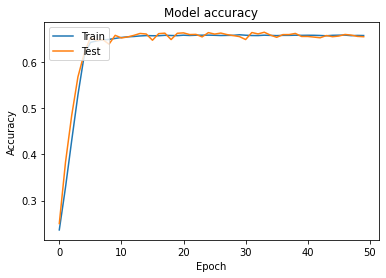

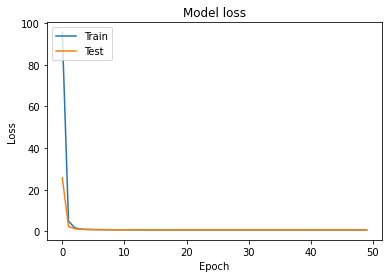

In [7]:
history = histories["(SM)"]

# Plot training & validation accuracy values
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

In [8]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

y_pred = models["(20, SM)"].predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

bac = balanced_accuracy_score(y_true, y_pred)
print(bac)
cm = confusion_matrix(y_true, y_pred, labels=range(0, nmax + 1))
print(cm)
cmrel = confusion_matrix(y_true, y_pred, labels=range(0, nmax + 1), normalize="true")
print(cmrel)

0.6679795786295759
[[12851    14     3     0     0]
 [    0 47500  3927    13     3]
 [    0 16749 21634  8449    67]
 [    0  2749 10288 17316  4027]
 [    0   189  1394  6033  6305]]
[[0.999 0.001 0.    0.    0.   ]
 [0.    0.923 0.076 0.    0.   ]
 [0.    0.357 0.461 0.18  0.001]
 [0.    0.08  0.299 0.504 0.117]
 [0.    0.014 0.1   0.433 0.453]]
